In [2]:
%matplotlib notebook

import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)
import pandas as pd 

In [4]:
#reading data from csv 
df = pd.read_csv('datasets_12603_17232_Life Expectancy Data.csv')

In [5]:
#dealing with NA and analysing the shape of dataframe
df = df.fillna(df.mean())
print(df.shape)

(2938, 22)


In [7]:
#extract dataframes corresponding to countries
def countryDF(country):
    countryData = df[df['Country'] == country]
    return countryData


#extract columns
def columnExtractor(dataframe, columnName):
    values = dataframe[columnName]
    return values 

<IPython.core.display.Javascript object>


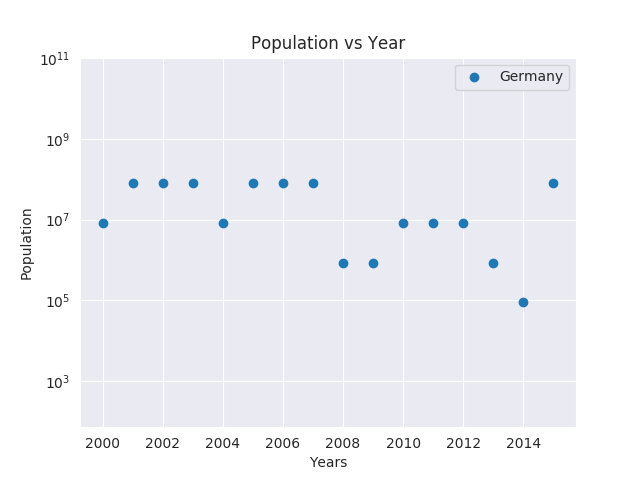

In [8]:
def plotPopulation(qty1, qty2, label):
    plt.yscale('log')
    plt.ylabel('Population')
    plt.xlabel('Years')
    plt.scatter(qty1, qty2, label=label)
    plt.title('Population vs Year')
    plt.legend()
    
    
# Population growth of 3 countries (Germany, Netherlands, Spain)
germanyDF = countryDF('Germany')
germanyPopulation = columnExtractor(germanyDF,'Population')
years = columnExtractor(germanyDF,'Year')
plotPopulation(years, germanyPopulation,label='Germany')

# netherlandsDF = countryDF('Netherlands')
# netherlandsPopulation = columnExtractor(netherlandsDF,'Population')
# plotPopulation(years, netherlandsPopulation, label='Netherlands')

# spainDF = countryDF('Spain')
# spainPopulation = columnExtractor(spainDF,'Population') 
# plotPopulation(years, spainPopulation, label='Spain')

# italyDF = countryDF('Italy')
# italyPopulation = columnExtractor(italyDF,'Population') 
# plotPopulation(years, italyPopulation, label='Italy')

# franceDF = countryDF('France')
# francePopulation = columnExtractor(franceDF,'Population') 
# plotPopulation(years, francePopulation, label='France')

plt.show()

In [9]:
def exponentiated_quadratic(xa, xb):
    sq_norm = -0.5*scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [10]:
xlim = (2000, 2020)
X = np.expand_dims(np.linspace(*xlim, 25), 1)
Σ = exponentiated_quadratic(X, X)

In [11]:
xlim = (2000, 2020)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)
zero = np.array([[0]])
Σ0 = exponentiated_quadratic(X, zero)

In [12]:
# Sample from the Gaussian process distribution
nb_of_samples = 41  # Number of points in each function
number_of_functions = 3  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(2000, 2020, nb_of_samples), 1)
Σ = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

<IPython.core.display.Javascript object>


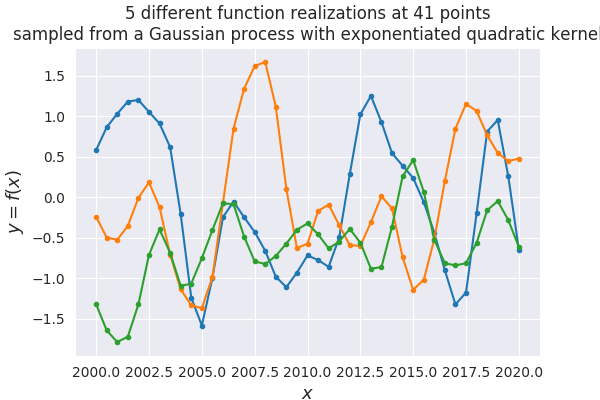

In [13]:
plt.figure(figsize=(6, 4))
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 different function realizations at 41 points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
#plt.xlim([-4, 4])
plt.show()
#

In [14]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [21]:
# Compute the posterior mean and covariance

n1 = 16  # Number of points to condition on (training points)
n2 = 16 # Number of points in posterior (test points)
ny = 3  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1,1))
y1 = germanyPopulation
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1,1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

<IPython.core.display.Javascript object>


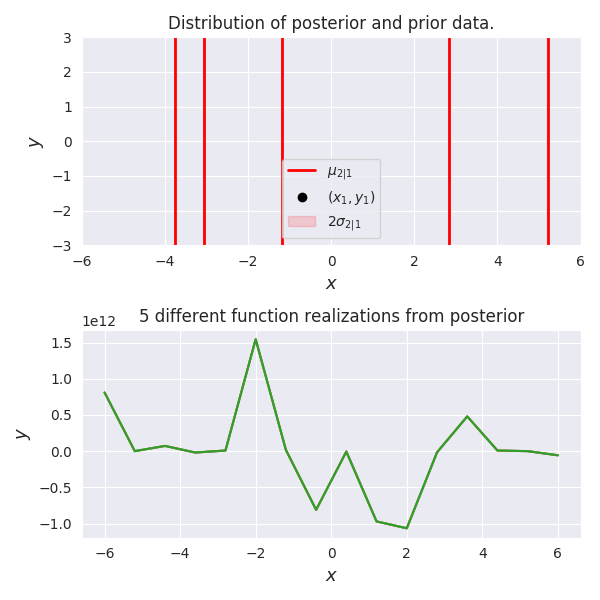

In [25]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
#ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
#ax2.set_xlim([-6, 6])
#plt.yscale('log')
plt.tight_layout()
plt.show()
#

In [ ]:
# def plotLifeExpectance(qty1, qty2, label):
#     plt.ylabel('BMI')
#     plt.xlabel('Years')
#     plt.plot(qty1, qty2, label=label)
#     plt.title('BMI vs Year')
#     plt.legend()
    
    
# # Population growth of 3 countries (Germany, Netherlands, Spain)
# germanyDF = countryDF('Germany')
# germanyBMI = columnExtractor(germanyDF,' BMI ')
# years = columnExtractor(germanyDF,'Year')
# plotLifeExpectance(years, germanyBMI,label='Germany')



    
    
    